# Predicción de default financiero usando métodos de aprendizaje automático

**Estudiantes**

Federico Ocampo Ortiz, Ing. Sistemas. e-mail: federico.ocampoo@udea.edu.co

Andrés Felipe Orrego Quintero. Ing. Sistemas. e-mail: andres.orrego2@udea.edu.co

**Asesora**

Maria Bernarda Salazar Sánchez, PhD. e-mail: bernarda.salazar@udea.edu.co

## **Líbrerías y funciones**

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Separación dataset
from sklearn import metrics # Metricas para la evaluación
from sklearn.neighbors import LocalOutlierFactor


In [20]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=100,ax=ax)
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        ax.xaxis.label.set_color('black')  
        ax.yaxis.label.set_color('black')          
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


In [2]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')

In [3]:
# If you are using kaggle, use this to download dataset in the same folder
import os
os.system('kaggle competitions download -c GiveMeSomeCredit -p ./data')

1

## **Dataset**

In [4]:
d.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


### **Renombrando variables**
<br> Estas especificaciones están contenidas en la Tabla 2 del trabajo de monografía.

In [7]:
# renombramiento de variables
# TODO: Cambiar nombres de variables para que sean más dicientes
d.rename(
    columns={
        "RevolvingUtilizationOfUnsecuredLines": "Cupos",
        "age": "Edad",
        "NumberOfTime30-59DaysPastDueNotWorse": "Mora30a59",
        "DebtRatio": "RatioDeuda",
        "MonthlyIncome": "IngresoMensual",
        "NumberOfOpenCreditLinesAndLoans": "LineasCredito",
        "NumberOfTimes90DaysLate": "MoraMayorA90",
        "NumberRealEstateLoansOrLines": "CreditosHipotecarios",
        "NumberOfTime60-89DaysPastDueNotWorse": "Mora60a89",
        "NumberOfDependents": "Dependientes",
        "SeriousDlqin2yrs": "Incumplimiento"
    },
    inplace=True,
)

La primera columna de los datos de entrenamiento y validación identificada como `Unnamed: 0` corresponde a un identificador de fila que no aporta valor al modelo, por lo tanto se elimina.

In [5]:
#Borrando columnas que no se emplearán
d.drop(['Unnamed: 0'], axis='columns', inplace=True)

Se encuentra un único registro con `Edad` igual a cero el cual es eliminado. Los valores desconocidos de `Ingreso Mensual` son remplazados por la media. Por último los valores nulos de `Dependientes` son imputados con la media de la característica.

In [11]:
d = d[d['Edad'] != 0]
d["IngresoMensual"] = d["IngresoMensual"].replace(np.nan, d["IngresoMensual"].median())
d["Dependientes"].fillna(d["Dependientes"].median(), inplace=True)

**Dimensiones y tipos de variables**

In [12]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Incumplimiento        149999 non-null  int64  
 1   Cupos                 149999 non-null  float64
 2   Edad                  149999 non-null  int64  
 3   Mora30a59             149999 non-null  int64  
 4   RatioDeuda            149999 non-null  float64
 5   IngresoMensual        149999 non-null  float64
 6   LineasCredito         149999 non-null  int64  
 7   MoraMayorA90          149999 non-null  int64  
 8   CreditosHipotecarios  149999 non-null  int64  
 9   Mora60a89             149999 non-null  int64  
 10  Dependientes          149999 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


**Histogramas**
<br> La base de datos contiene información de población entre los 20 y 80 años (distribución gausiana) con 0 personas a cargo (dependientes) en su gran mayoría, los cuales adquieren más de 2 créditos de forma simultánea (campana a la izquierda `LineasCredito`)

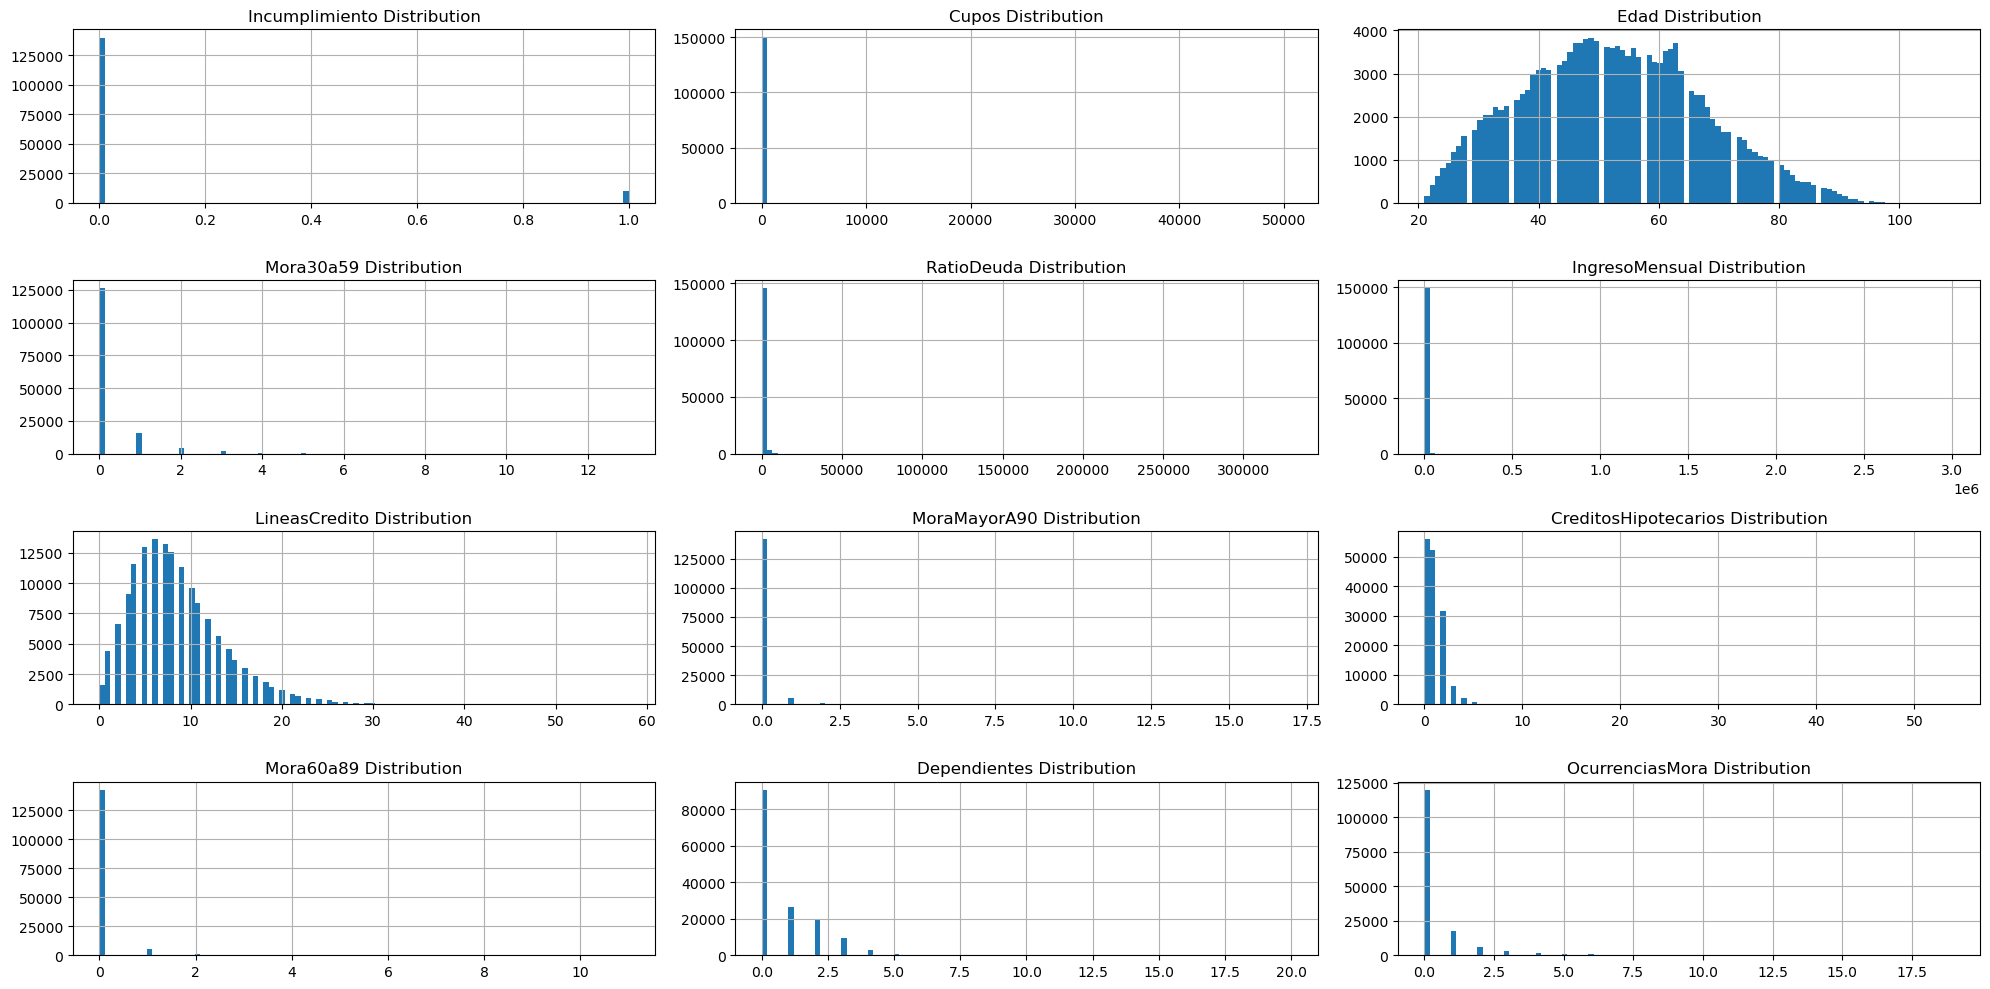

In [21]:
#Lista de variables numéricas
numCols=d.select_dtypes(include = ['float64','int32','int64']).columns.tolist()

# filter d only with numCols columns
draw_histograms(d[numCols], d[numCols].columns, 4, 3)

### **Análisis de la relación lineal entre las variables**

OJOJOJOJOJ Falta escribir algo aquí sobre lo que se verá en la matriz

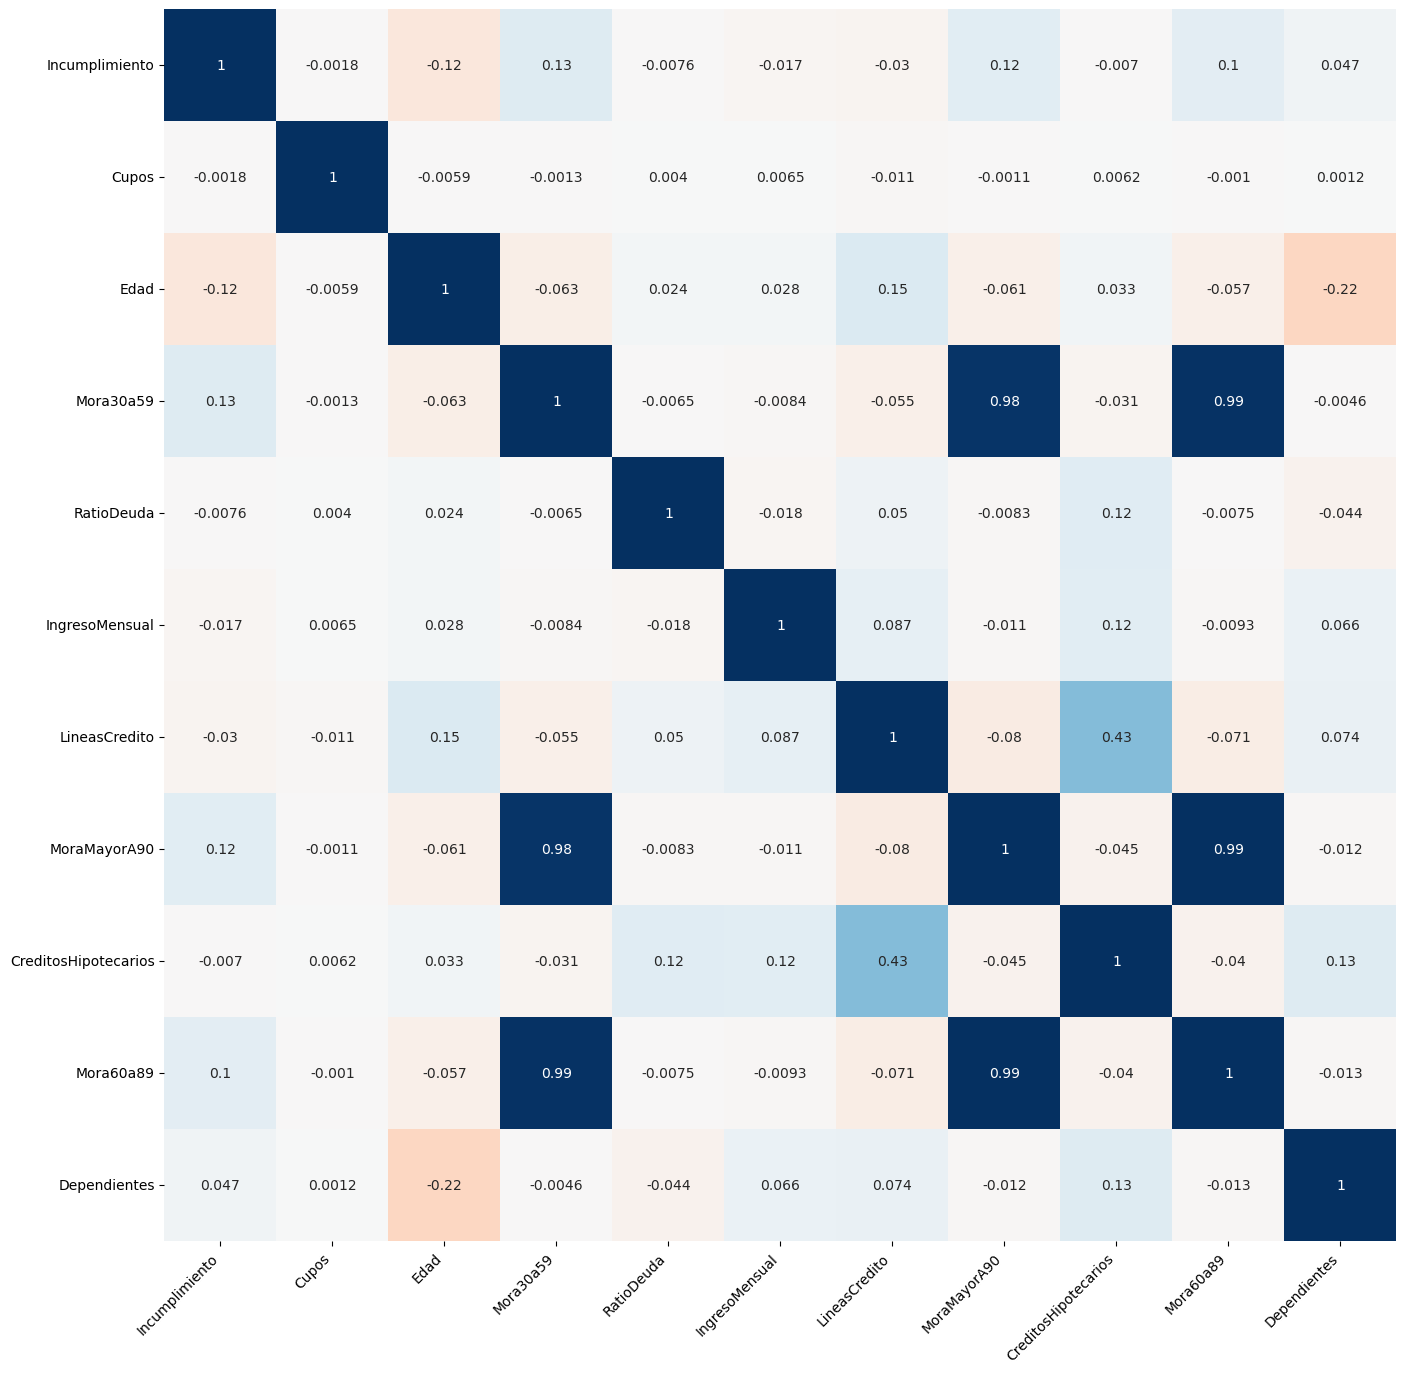

In [13]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

## **Detección de atípicos**

### **Atípicos variables ocurrencias de mora**

**Análisis de distribución de las variables categóricas para una ventana de dos años (730 días)**. Se definen como valores atípicos para esta ventana de tiempo registros cuyo valor sea superior a:
* 25 ocurrencias de mora en la ventana de 30 a 59 días
* 13 ocurrencias de mora en la ventana de 60 a 89 días

In [14]:
days_in_two_years = 365 * 2
max_possible_mora30_59 = math.ceil(days_in_two_years / 30)
print(f"Maximum value for Mora30a59: {max_possible_mora30_59}")

max_possible_mora60_89 = math.ceil(days_in_two_years / 60)
print(f"Maximum value for Mora60a89: {max_possible_mora60_89}")

print(f"Instances with Mora30a59 > {max_possible_mora30_59}: {len(d[d['Mora30a59'] > max_possible_mora30_59])}" )
print(f"Instances with Mora60a89 > {max_possible_mora60_89}: {len(d[d['Mora60a89'] > max_possible_mora60_89])}" )

Maximum value for Mora30a59: 25
Maximum value for Mora60a89: 13
Instances with Mora30a59 > 25: 269
Instances with Mora60a89 > 13: 269


Basados en el análisis anterior se borran los registros que están por fuera de los límites establecidos para las variables `Mora30a59` y `Mora60a89`

In [15]:
print(f"length of dataset before deleting {len(d)}")

# remove instances with Mora30a59 > max_possible_mora30_59 or Mora60a89 > max_possible_mora60_89
d = d[(d['Mora30a59'] <= max_possible_mora30_59) & (d['Mora60a89'] <= max_possible_mora60_89)]

print(f"length of dataset after deleting {len(d)}")

length of dataset before deleting 149999
length of dataset after deleting 149730


Cálculo de la **nueva variable** `OcurrenciasMora`
<br>Esta variable es la suma de las ocurrencias de mora en las ventanas de 30 a 59 días, 60 a 89 días y mayor a 90 días para cada registro.

In [16]:
# calculate new variable with the number of moras
d['OcurrenciasMora'] = d['Mora30a59'] + d['Mora60a89'] + d['MoraMayorA90']

d['OcurrenciasMora'].describe()

count    149730.000000
mean          0.401069
std           1.102150
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: OcurrenciasMora, dtype: float64

Análisis de la relación lineal **POS eliminación de atípicos ocurrencias por mora**

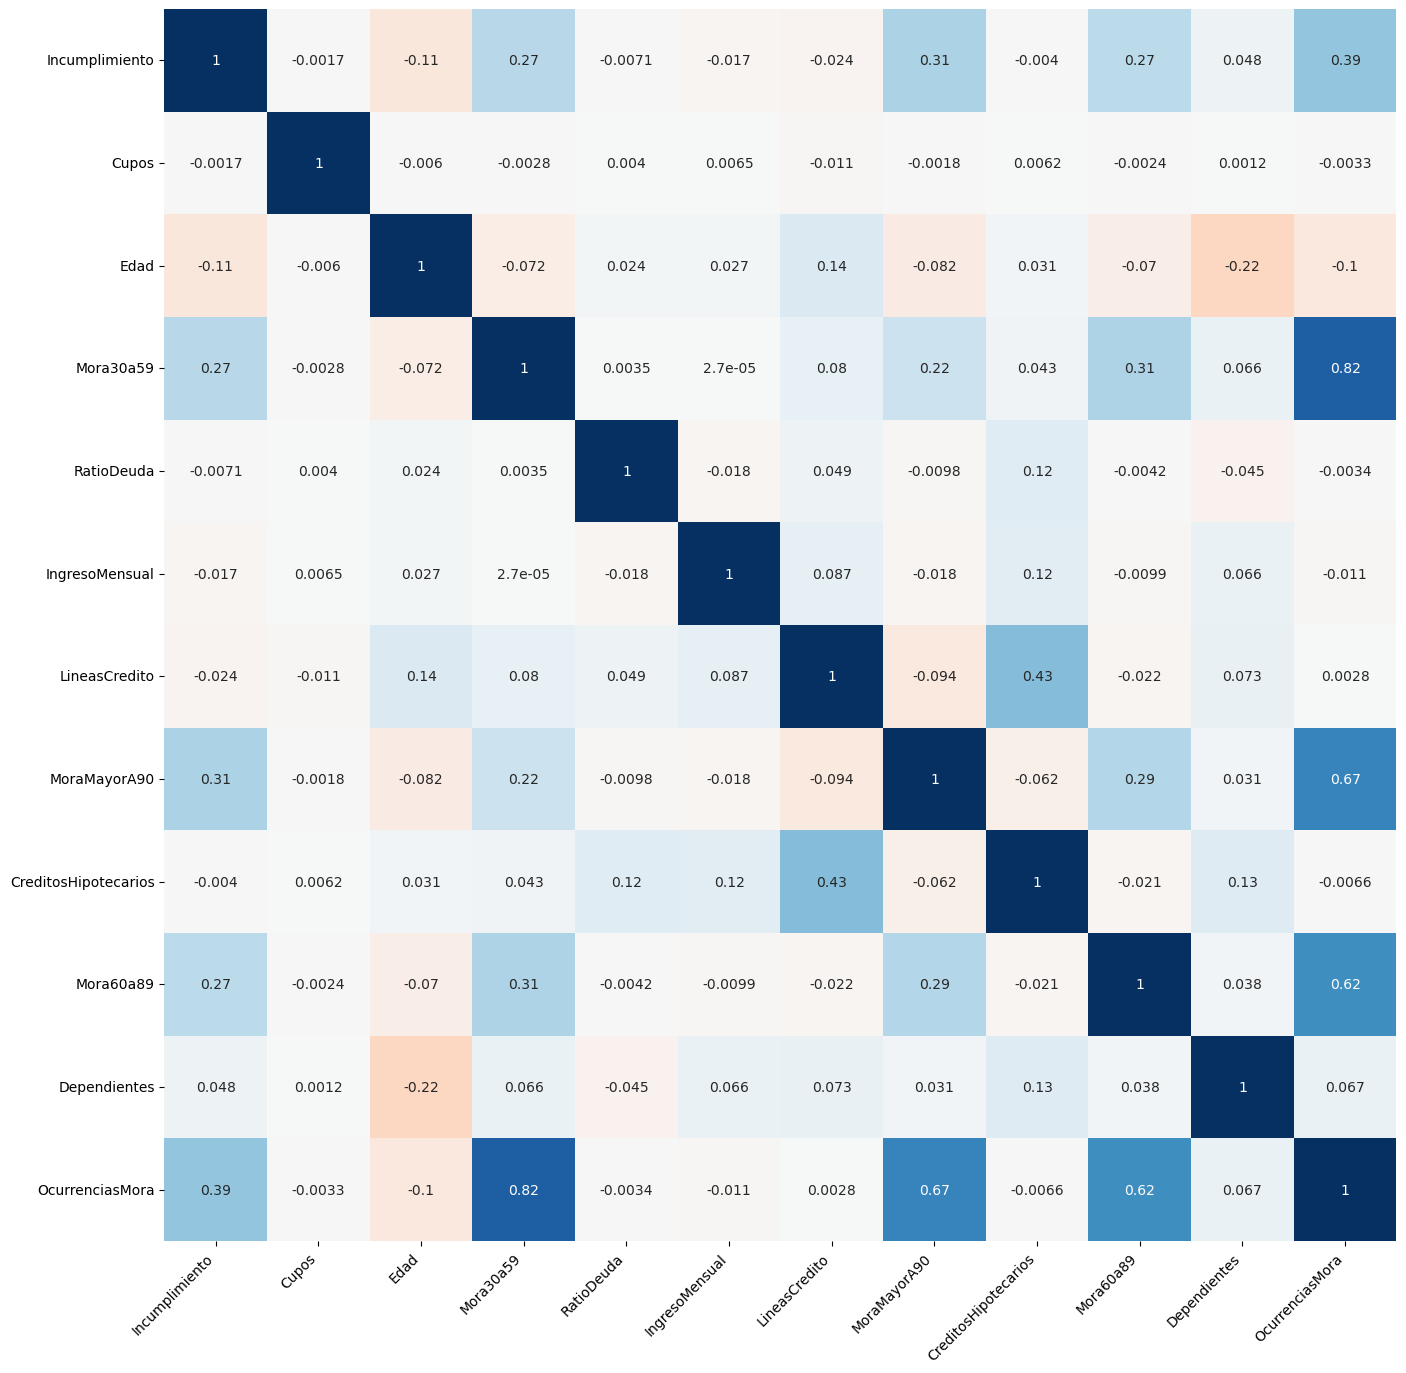

In [17]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Al eliminar los valores atípicos de las variables temporales `Mora30a59` y `Mora60a89` se puede observar como se redefine la relación lineal entre las variables, pasando de ~0.98 a ~0.20. Sin embargo, se sigue evidenciando que estas variables tienen una correlación más alta en comparación con las demás variables en la base de datos.
<br> También se puede evidenciar que en general las variables analizadas no están directamente correlacionadas con la variable de interés para la clasificación (`Incumplimiento`), se obtienen valores de correlación menores a 0.31 en todos los casos.

### **Atípicos utilizando LOF**

Eliminación de valores atípicos utilizando el método Detección de valores atípicos con Local Outlier Factor [(LOF)](https://qu4nt.github.io/sklearn-doc-es/auto_examples/neighbors/plot_lof_outlier_detection.html). La puntuación de anomalía de cada muestra se denomina Factor de Anomalía Local. Mide la desviación local de la densidad de una muestra dada con respecto a sus vecinos. Es local en el sentido de que el valor de la anomalía depende de lo aislado que esté el objeto con respecto al vecindario circundante. Más concretamente, la localidad viene dada por los k vecinos más cercanos, cuya distancia se utiliza para estimar la densidad local. Comparando la densidad local de una muestra con las densidades locales de sus vecinos, se pueden identificar las muestras que tienen una densidad sustancialmente menor que sus vecinos. Estas se consideran valores atípicos.

In [22]:
# crear un objeto LocalOutlierFactor con n_neighbors=14
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)

y_pred = lof.fit_predict(d[numCols])

outliers = y_pred == -1

print(f"Valores atípicos detectados: {np.count_nonzero(outliers)}")
#print('Indices de valores atípicos: ', d[outliers].index.tolist())

Valores atípicos detectados: 14973


In [19]:
d.describe()

,Incumplimiento,Cupos,Edad,Mora30a59,RatioDeuda,IngresoMensual,LineasCredito,MoraMayorA90,CreditosHipotecarios,Mora60a89,Dependientes
count,149731.000000,149731.000000,149731.000000,149731.000000,149731.000000,1.201210e+05,149731.000000,149731.000000,149731.000000,149731.000000,145838.000000
mean,0.065978,6.057508,52.327634,0.245794,353.628957,6.675289e+03,8.467932,0.090456,1.020069,0.064823,0.757855
std,0.248245,249.979529,14.754942,0.697780,2039.594737,1.439249e+04,5.138094,0.485527,1.129960,0.330073,1.115383
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029771,41.000000,0.000000,0.175998,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.153491,52.000000,0.000000,0.367119,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.555601,63.000000,0.000000,0.870021,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,13.000000,329664.000000,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


In [122]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149731 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Incumplimiento        149731 non-null  int64  
 1   Cupos                 149731 non-null  float64
 2   Edad                  149731 non-null  int64  
 3   Mora30a59             149731 non-null  int64  
 4   RatioDeuda            149731 non-null  float64
 5   IngresoMensual        149731 non-null  float64
 6   LineasCredito         149731 non-null  int64  
 7   MoraMayorA90          149731 non-null  int64  
 8   CreditosHipotecarios  149731 non-null  int64  
 9   Mora60a89             149731 non-null  int64  
 10  Dependientes          149731 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [17]:
df = d[~outliers]

In [43]:
df.describe()

,SeriousDlqin2yrs,Cupos,Edad,Mora30a59,RatioDeuda,IngresoMensual,LineasCredito,MoraMayorA90,CreditosHipotecarios,Mora60a89,Dependientes
count,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000
mean,0.059978,3.251146,52.178541,0.290156,360.498768,6255.201681,8.110393,0.145644,0.995578,0.130311,0.721459
std,0.237447,122.056926,14.359014,2.780406,1126.521941,5622.549191,4.543916,2.742489,1.046736,2.732551,1.078992
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029158,41.000000,0.000000,0.179260,3945.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.148095,52.000000,0.000000,0.369687,5400.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.542595,62.000000,0.000000,0.935610,7229.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,11843.000000,99.000000,98.000000,40385.000000,304000.000000,48.000000,98.000000,32.000000,98.000000,10.000000


In [18]:
# Exportar df a csv
nombre_archivo = 'data/Preprocessed.csv'

df.to_csv(nombre_archivo, index=False)